In [4]:
# !pip install html2image
runcode = False # set to True to run code that queries wikipedia for more cards.
restarting_requested = False # set to True to restart the kernel and run the code again, will set the json file to blank, so you can start over.
reset_cardbox = True # set to True to reset the cardbox, will remove all cards from the cardbox.

In [5]:
# refresh (reset) the ppn_deck.json file with one card only (the first card)
# this is useful when you want to start over with a new deck
# you can also use this to create a new deck from scratch
import json
if restarting_requested:
    starter = [{
            "title": "Michael Buffer",
            "summary": [
                "Michael Buffer",
                "Michael Buffer born November 2, 1944 is an American ring announcer or MC for boxing, professional wrestling, and National Football League matches. He is known for his trademarked catchphrase: Lets get ready to rumble!"
            ],
            "related": 174
        },
        {
            "title": "Clapton is God",
            "summary": [
                "Clapton is God",
                "Clapton is God is a 1960s meme referencing the English guitarist Eric Clapton. The line was popularised after being spray-painted on a wall in London during the mid-1960s, when Clapton was a member of the Yardbirds and John Mayall & the Bluesbreakers, creating the cult of the guitar hero."
            ],
            "related": 168
        }
    ]
    with open('ppn_deck.json', 'w') as f:
        json.dump(starter, f)
else:
    with open('ppn_deck.json', 'r') as f:
        starter = json.load(f)


In [6]:
if runcode:
    !python wiki_monikers.py

# Run From here to create Cards

In [7]:
!python card_point_revision.py

100%|██████████████████████████████████| 4179/4179 [00:00<00:00, 1249589.82it/s]


In [8]:
# # Now we create a deck of cards from the json file
# !python card_engine.py

# Start Here

In [9]:
import textstat
import json
from tqdm import tqdm
import re
def determine_grade_level(summary: str):# -> float:
    """
    determine_grade_level - generates a grade level for the given summary using the Flesch-Kincaid Grade Level formula

    The Flesch-Kincaid Grade Level formula is a readability test designed to indicate how difficult a passage in English is to understand. The score is based on the average number of syllables per 100 words and the average number of words per sentence. The higher the score, the more difficult the text is to understand.

    :param summary: _description_
    :type summary: _type_
    :return: _description_
    :rtype: float
    """
    grade_level = textstat.flesch_kincaid_grade(str(summary))
    return grade_level

In [10]:
# delete the cards in the new_card_box folder
if reset_cardbox:
    !rm -rf new_card_box/*

In [11]:
try:
    !python balancing_the_deck.py
except:
    print('error in balancing the deck')

python: can't open file '/Users/grahamwaters/Library/Mobile Documents/com~apple~CloudDocs/Mimikers/balancing_the_deck.py': [Errno 2] No such file or directory


In [12]:
with open('ppn_deck.json', 'r') as read_file:
    card_deck = json.load(read_file)



In [13]:
# for each of the cards, generate a grade_level score and add it to the json file under the key "grade_level"
for card in tqdm(card_deck):
    try:
        summary = card['summary']
        grade_level = determine_grade_level(summary)
        card['grade_level'] = grade_level
    except Exception as e:
        #print(e)
        # if there is an error, set the grade_level to 0
        card['grade_level'] = 0

100%|██████████| 4179/4179 [00:02<00:00, 1449.90it/s]


In [14]:
# add length of summary to the df column "summary_length"
import pandas as pd
df = pd.DataFrame(card_deck)
df['summary_length'] = df['summary'].apply(lambda x: len(x))


In [15]:
# convert the card_deck to a json file, to a df using pandas and then to a csv file
with open("ppn_deck_cleaned.json", "w") as write_file:
    json.dump(card_deck, write_file, indent=4)

# read card_deck from ppn_deck.json file
# with open("ppn_deck.json", "r") as read_file:
# card_deck = json.load(read_file)
with open("ppn_deck_cleaned.json", "r") as read_file:
    card_deck = json.load(read_file)
    
# convert card_deck to a pandas dataframe
df.head()

,title,summary,related,point_value,grade_level,summary_length,points_for_card,acronym,years_in_summary,years_in_title,points_by_year_mentioned,summary_short,category
0,Michael Buffer,"['Michael Buffer', 'Michael Buffer born Novemb...",174,174,9.1,239,1.0,False,1.0,0.0,1.0,"['Michael Buffer', 'Michael Buffer born Novemb...",NaN
1,Kwang Soo Kim,"['Kwang Soo Kim', 'Kwang Soo Kim, Kwang Soo Ki...",53,53,11.1,758,6.0,False,5.0,0.0,2.0,"('Kwang Soo Kim', 'Kwang Soo Kim, Kwang Soo Ki...",NaN
2,Fame in the 20th Century,"['Fame in the 20th Century', 'Fame in the 20th...",591,591,10.8,1178,6.0,False,4.0,0.0,2.0,"('Fame in the 20th Century', 'Fame in the 20th...",NaN
3,Lock of hair,"['Lock of hair', 'Lock of hair, A lock of hair...",247,247,8.9,275,1.0,False,0.0,0.0,1.0,"('Lock of hair', 'Lock of hair, A lock of hair...",NaN
4,Johnny Depp,"['Johnny Depp', 'Johnny Depp, John Christopher...",875,875,12.8,2752,6.0,False,36.0,0.0,2.0,"('Johnny Depp', 'Johnny Depp, John Christopher...",NaN


In [16]:
# points for the card should be calculated by the following formula:
# - the higher the grade level of the card, the higher the points.
# - the more words in the summary, the lower the points.
# - cards with longer titles should have higher points.
# - cards with Acronyms should have higher points.

# create a new column in the dataframe called "points_for_card"
df['points_for_card'] = 0
df['acronym'] = False # this will need to be updated later to determine if the card has an acronym or not

def determine_points(card):
    # determine the points for the card based on the following formula:
    # - the higher the grade level of the card, the higher the points.
    # - the more words in the summary, the lower the points.
    # - cards with longer titles should have higher points.
    # - cards with Acronyms should have higher points.
    grade_level = card['grade_level']
    summary = card['summary']
    title = card['title']
    acronym = card['acronym']
    related_pages = card['related']
    points = 0
    # - the higher the grade level of the card, the higher the points.
    # all _score variables will be between 0 and 100
    grade_score = grade_level
    # - the more words in the summary, the lower the points.
    if isinstance(summary, str):
        summary_score = len(summary.split())
    else:
        summary_score = len(summary)
    # - cards with longer titles should have higher points.
    if isinstance(title, str):
        title_score = len(title.split())
    else:
        title_score = len(title)
    # - cards with Acronyms should have higher points.
    acronym_score = 0
    if acronym:
        acronym_score = 1
    # - cards with related pages should have higher points.
    try:
        related_pages_score = int(related_pages)
    except ValueError:
        related_pages_score = 0
    except Exception:
        related_pages_score = 0
    #print(grade_score)
    #print(summary_score)
    #print(title_score)
    #print(acronym_score)

    #print(related_pages_score)

    # calculate the points
    points = grade_score + summary_score + title_score + acronym_score + related_pages_score
    #print(points)

    return int(points)

# apply the determine_points function to each of the cards in the dataframe
df['points_for_card'] = df.apply(determine_points, axis=1)
# now scale the points_for_card column to be between 1 and 10, and round to the nearest integer
df['points_for_card'] = df['points_for_card'].apply(lambda x: round((x - df['points_for_card'].min()) / (df['points_for_card'].max() - df['points_for_card'].min()) * 10))
# replace any points_for_card values that are 0 with 1
df['points_for_card'] = df['points_for_card'].apply(lambda x: 1 if x == 0 else x)
# no card with a grade level above 10 should have a points_for_card value less than 5
df['points_for_card'] = df.apply(lambda x: 5 if x['grade_level'] > 10 and x['points_for_card'] < 5 else x['points_for_card'], axis=1)
df.head()

,title,summary,related,point_value,grade_level,summary_length,points_for_card,acronym,years_in_summary,years_in_title,points_by_year_mentioned,summary_short,category
0,Michael Buffer,"['Michael Buffer', 'Michael Buffer born Novemb...",174,174,9.1,239,1,False,1.0,0.0,1.0,"['Michael Buffer', 'Michael Buffer born Novemb...",NaN
1,Kwang Soo Kim,"['Kwang Soo Kim', 'Kwang Soo Kim, Kwang Soo Ki...",53,53,11.1,758,5,False,5.0,0.0,2.0,"('Kwang Soo Kim', 'Kwang Soo Kim, Kwang Soo Ki...",NaN
2,Fame in the 20th Century,"['Fame in the 20th Century', 'Fame in the 20th...",591,591,10.8,1178,5,False,4.0,0.0,2.0,"('Fame in the 20th Century', 'Fame in the 20th...",NaN
3,Lock of hair,"['Lock of hair', 'Lock of hair, A lock of hair...",247,247,8.9,275,1,False,0.0,0.0,1.0,"('Lock of hair', 'Lock of hair, A lock of hair...",NaN
4,Johnny Depp,"['Johnny Depp', 'Johnny Depp, John Christopher...",875,875,12.8,2752,5,False,36.0,0.0,2.0,"('Johnny Depp', 'Johnny Depp, John Christopher...",NaN


In [17]:
df['years_in_summary'] = df['summary'].apply(lambda x: len(re.findall(r'\d{4}', str(x))))
df['years_in_title'] = df['title'].apply(lambda x: len(re.findall(r'\d{4}', str(x))))

In [18]:
# look for years in the summary and title. Older cards should have higher points, so we will add 1 point for each year found in the summary and title (this will be scaled later)
import re

def points_by_year_mentioned(this_card,years_in_deck):
    # assign higher points for years that are older (i.e 1980 has higher points than 2010 etc.) This is on a scale so highest points are for the oldest years.
    # this card may mention multiple years, so we will add the points for each year mentioned by where it falls in the scale of years in the deck.
    # for example, if the card mentions 1980 and 2010, and the deck has cards from 1980 to 2020, then the points for the card will be 1 + 10 = 11
    points = 0
    years_in_summary = this_card['years_in_summary']
    years_in_title = this_card['years_in_title']
    years_mentioned = years_in_summary + years_in_title
    if years_mentioned > 0:
        # get the year mentioned in the summary and title
        years = re.findall(r'\d{4}', this_card['summary']) + re.findall(r'\d{4}', this_card['title'])
        # convert the years to integers
        years = [int(x) for x in years]
        # get the min and max year in the deck
        min_year = min(years_in_deck)
        max_year = max(years_in_deck)
        # get the range of years in the deck
        range_of_years = max_year - min_year
        # get the range of points
        range_of_points = 10
        # get the points for each year mentioned
        for year in years:
            try:
                points_for_year = round((year - min_year) / range_of_years * range_of_points)
                points += points_for_year
            except ZeroDivisionError:
                points += 0 # if the range of years is 0, then the points for the year will be 0
            except Exception:
                points += 0
    return points

# get the years in the deck by looking at all summaries and titles for years and getting the unique years mentioned. years are between 1950 and 2022.
years_in_deck = []
# convert the row summary, title to a string type
df['summary'] = df['summary'].apply(lambda x: str(x))
df['title'] = df['title'].apply(lambda x: str(x))
for index, row in df.iterrows():
    years_in_deck += re.findall(r'\d{4}', row['summary'])
    years_in_deck += re.findall(r'\d{4}', row['title'])
# convert the years to integers
years_in_deck = [int(x) for x in years_in_deck]
# get the unique years
years_in_deck = list(set([int(x) for x in years_in_deck]))
# sort the years
years_in_deck.sort()
# filter out years that are not between 1950 and 2022
years_in_deck = [x for x in years_in_deck if x >= 1950 and x <= 2022]
# print(years_in_deck)
# apply the points_by_year_mentioned function to each of the cards in the dataframe
df['points_by_year_mentioned'] = df.apply(lambda x: points_by_year_mentioned(x,years_in_deck), axis=1)

# now scale the points_by_year_mentioned column to be between 1 and 10, and round to the nearest integer
try:
    df['points_by_year_mentioned'] = df['points_by_year_mentioned'].apply(lambda x: round((x - df['points_by_year_mentioned'].min()) / (df['points_by_year_mentioned'].max() - df['points_by_year_mentioned'].min()) * 10))
except ZeroDivisionError:
    df['points_by_year_mentioned'] = 0 # if the range of years is 0, then the points for the year will be 0
except ValueError:
    df['points_by_year_mentioned'] = 0 # if the range of years is 0, then the points for the year will be 0

# replace any points_by_year_mentioned values that are 0 with 1
df['points_by_year_mentioned'] = df['points_by_year_mentioned'].apply(lambda x: 1 if x == 0 else x)

# now add the points_by_year_mentioned to the points_for_card
df['points_for_card'] = df['points_for_card'] + df['points_by_year_mentioned']

try:
    # now scale the points_for_card column to be between 1 and 10, and round to the nearest integer
    df['points_for_card'] = df['points_for_card'].apply(lambda x: round((x - df['points_for_card'].min()) / (df['points_for_card'].max() - df['points_for_card'].min()) * 10))
except ZeroDivisionError:
    df['points_for_card'] = 0 # if the range of years is 0, then the points for the year will be 0
except ValueError:
    df['points_for_card'] = 0 # if the range of years is 0, then the points for the year will be 0
except Exception:
    df['points_for_card'] = 0 # if the range of years is 0, then the points for the year will be 0
    raise(Exception, 'Error in scaling points_for_card')
    # replace any points_for_card values that are 0 with 1
    df['points_for_card'] = df['points_for_card'].apply(lambda x: 1 if x == 0 else x)
df.head()

,title,summary,related,point_value,grade_level,summary_length,points_for_card,acronym,years_in_summary,years_in_title,points_by_year_mentioned,summary_short,category
0,Michael Buffer,"['Michael Buffer', 'Michael Buffer born Novemb...",174,174,9.1,239,0,False,1,0,1,"['Michael Buffer', 'Michael Buffer born Novemb...",NaN
1,Kwang Soo Kim,"['Kwang Soo Kim', 'Kwang Soo Kim, Kwang Soo Ki...",53,53,11.1,758,5,False,5,0,2,"('Kwang Soo Kim', 'Kwang Soo Kim, Kwang Soo Ki...",NaN
2,Fame in the 20th Century,"['Fame in the 20th Century', 'Fame in the 20th...",591,591,10.8,1178,5,False,4,0,2,"('Fame in the 20th Century', 'Fame in the 20th...",NaN
3,Lock of hair,"['Lock of hair', 'Lock of hair, A lock of hair...",247,247,8.9,275,0,False,0,0,1,"('Lock of hair', 'Lock of hair, A lock of hair...",NaN
4,Johnny Depp,"['Johnny Depp', 'Johnny Depp, John Christopher...",875,875,12.8,2752,5,False,36,0,2,"('Johnny Depp', 'Johnny Depp, John Christopher...",NaN


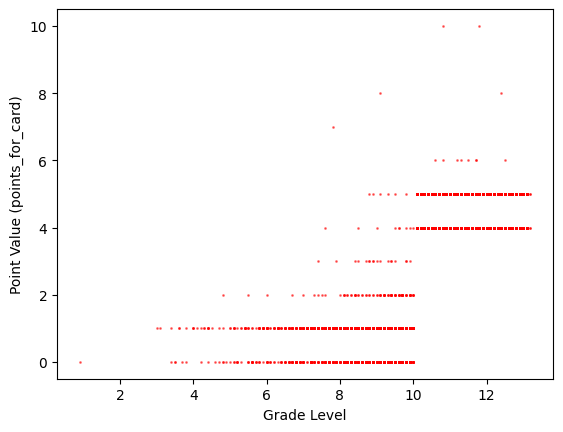

In [19]:
# remove cards that are beyond the 95th percentile using IQR method
# calculate the 95th percentile
grade_level_95th_percentile = df['grade_level'].quantile(0.95)
# remove cards that are beyond the 95th percentile
df = df[df['grade_level'] < grade_level_95th_percentile]
# remove any cards with negative point values or grade levels
df = df[df['point_value'] > 0]
df = df[df['grade_level'] > 0]
# show the distribution of grade levels

# plot grade levels vs point values
import matplotlib.pyplot as plt
plt.scatter(df['grade_level'], df['points_for_card'], color='red', alpha=0.5, s=1)
plt.xlabel('Grade Level')
plt.ylabel('Point Value (points_for_card)')
plt.show()

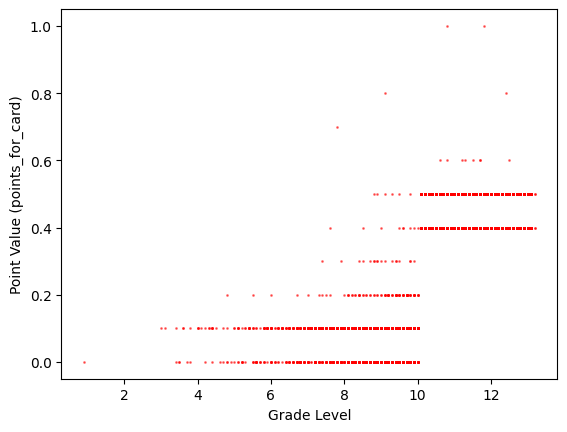

In [20]:
# use min-max normalization to normalize the point values
# calculate the min and max point values
min_point_value = df['points_for_card'].min()
max_point_value = df['points_for_card'].max()
# normalize the point values
df['points_for_card'] = (df['points_for_card'] - min_point_value) / (max_point_value - min_point_value)
# plot grade levels vs point values
import matplotlib.pyplot as plt
plt.scatter(df['grade_level'], df['points_for_card'], color='red', alpha=0.5, s=1)
plt.xlabel('Grade Level')
plt.ylabel('Point Value (points_for_card)')
plt.show()


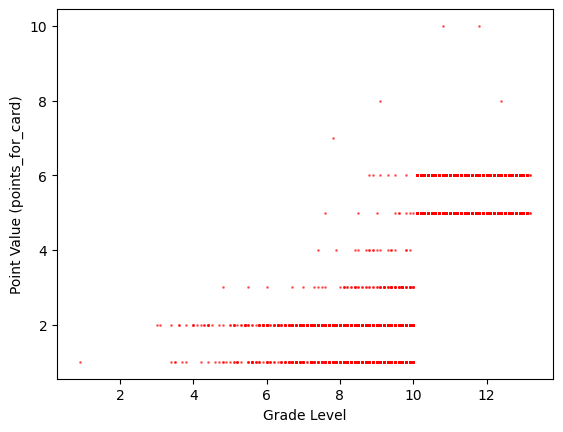

In [21]:
# now use minmaxscaler to normalize the point values between 0, and 10 by steps of 1 (i.e. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10) using rounding to the nearest integer. This will be used to generate the point values for the cards.
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(1, 10))
# fit the scaler to the point values
if df[['points_for_card']].empty:
    # handle empty dataframe
    raise ValueError('Empty dataframe')
else:
    scaler.fit(df[['points_for_card']])
# transform the point values
df['points_for_card'] = scaler.transform(df[['points_for_card']])
# round the point values to the nearest integer
df['points_for_card'] = df['points_for_card'].round()
# plot grade levels vs point values
import matplotlib.pyplot as plt
plt.scatter(df['grade_level'], df['points_for_card'], color='red', alpha=0.5, s=1)
plt.xlabel('Grade Level')
plt.ylabel('Point Value (points_for_card)')
plt.show()

In [22]:
# save the dataframe to a json file in place of the ppn_deck.json file
df.to_json('ppn_deck.json', orient='records')


---

In [23]:
# now remove any cards with profanity in the title or summary
# !pip install sklearn --upgrade
# !pip install joblib --upgrade
# !pip install scipy --upgrade
# !pip install alt-profanity-check
from profanity_check import predict, predict_prob
# if the probability of profanity is greater than 0.7, then remove the card.
print(f'Number of cards before removing profanity: {len(df)}')
cards = len(df)
df['profanity'] = (predict_prob(df['title']) + predict_prob(df['summary'])) / 2 # calculate the average probability of profanity in the title and summary. This is a value between 0 and 1.
df = df[df['profanity'] < 0.7] # remove any cards with a probability of profanity greater than 0.7
df = df.drop(columns=['profanity']) # remove the profanity column
# save the dataframe to a json file in place of the ppn_deck.json file
print(f'Number of cards after removing profanity: {len(df)}')
final_cards= len(df)
# if there were cards with profanity then clear the deck folder and re-generate the deck files
reset_cardbox = True if cards != final_cards else False # if the number of cards before removing profanity is not equal to the number of cards after removing profanity, then reset the cardbox because there were cards with profanity ratings over 70%.
df.to_json('ppn_deck_clean.json', orient='records')
if reset_cardbox:
    !rm -rf new_card_box/*

Number of cards before removing profanity: 3963
Number of cards after removing profanity: 3962
zsh:1: no matches found: new_card_box/*


In [24]:
import time

if reset_cardbox:
    # save a backup of the original deck
    timestamp = time.strftime('%Y%m%d_%H%M%S') # get the current timestamp in the format YYYYMMDD_HHMMSS
    !cp ppn_deck.json ppn_deck_backup_{timestamp}.json # save a backup of the original deck in case something goes wrong
    !rm -rf new_card_box/*
    substitute_master_deck = True # if there were cards with profanity then clear the deck folder and re-generate the deck files
else:
    substitute_master_deck = False
    
if substitute_master_deck:
    # save the df to a json file in place of the ppn_deck.json file
    df.to_json('ppn_deck.json', orient='records')
    print(f'Saved cleaned deck to ppn_deck.json')

zsh:1: no matches found: new_card_box/*
Saved cleaned deck to ppn_deck.json


---

In [25]:
# import spacy


# import contextualSpellCheck
# nlp = spacy.load('en_core_web_sm')
# contextualSpellCheck.add_to_pipe(nlp)

In [26]:
# Now we create a deck of cards from the json file
!python card_engine.py

Initialized, ready to spell check!
Spell check complete, ready to generate cards!
From armentires is an english song that was particularly popular during world war i. it is also known by its ersatz french hook line, inky pinky parlez vous, or the american variant hinky dinky parlez- vous variant: parlay voo. inky pinky was a scottish childrens name for parsnip and potato cakes, but it has been suggested that an onomatopoeic reference to the sound of bed springs is a more likely soldiers ribald derivation.
objc[34669]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59435aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x114c63568). One of the two will be used. Which one is undefined.
[1229/004013.118758:INFO:headless_shell.cc(623)] Written to file /Users/graham